# **Installations**

In [1]:
#!pip install embedding_as_service
!pip uninstall torch torchvision -y
!pip install torch==1.6.0+cu101 torchvision==0.7.0+cu101 -f https://download.pytorch.org/whl/torch_stable.html
!pip install -U transformers==2.10.0
!pip install -U simpletransformers==0.22.0
!pip install tweet-preprocessor
#!pip install commands
#!pip install gputil
#!pip install psutil
#!pip install humanize

Uninstalling torch-1.6.0+cu101:
  Successfully uninstalled torch-1.6.0+cu101
Uninstalling torchvision-0.7.0+cu101:
  Successfully uninstalled torchvision-0.7.0+cu101
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 708.0MB 25kB/s 
     |████████████████████████████████| 5.9MB 2.7MB/s 
     |████████████████████████████████| 665kB 10.2MB/s 
     |████████████████████████████████| 1.1MB 44.3MB/s 
     |████████████████████████████████| 3.8MB 52.4MB/s 
     |████████████████████████████████| 890kB 52.8MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=ed1f3b1ffcc6e962ba77bec5d1d5a67075bd07285fcc7a1885ae56eb3156cd2b
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 153kB 9.2MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |█████████████████

# **Look for available GPUs**

In [2]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
import subprocess
print(subprocess.getoutput('nvidia-smi'))

Sun Nov  1 11:38:17 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# **Imports**

In [3]:
import pandas as pd
import numpy as np

import preprocessor as p
from tqdm.notebook import tqdm
tqdm.pandas()

from simpletransformers.classification import ClassificationModel
import logging
import sklearn

# **Train and test Data**

In [ ]:
df_train = pd.read_csv("/content/drive/My Drive/BTP_FakeNewsDetection/train.csv")
df_test = pd.read_csv("/content/drive/My Drive/BTP_FakeNewsDetection/test.csv")
print(df_train.shape, df_test.shape)

(29906, 7) (2177, 7)


In [ ]:
df_train.head()

,post_id,post_text,user_id,image_id(s),username,timestamp,label
0,324597532548276224,Don't need feds to solve the #bostonbombing wh...,886672620,"boston_fake_03,boston_fake_35",SantaCruzShred,Wed Apr 17 18:57:37 +0000 2013,fake
1,325145334739267584,PIC: Comparison of #Boston suspect Sunil Tripa...,21992286,boston_fake_23,Oscar_Wang,Fri Apr 19 07:14:23 +0000 2013,fake
2,325152091423248385,I'm not completely convinced that it's this Su...,16428755,boston_fake_34,jamwil,Fri Apr 19 07:41:14 +0000 2013,fake
3,324554646976868352,Brutal lo que se puede conseguir en colaboraci...,303138574,"boston_fake_03,boston_fake_35",rubenson80,Wed Apr 17 16:07:12 +0000 2013,fake
4,324315545572896768,4chan and the bombing. just throwing it out th...,180460772,boston_fake_15,Slimlenny,Wed Apr 17 00:17:06 +0000 2013,fake


In [ ]:
df_train.drop(df_train[df_train['label']=='humor'].index, inplace=True)
df_test.drop(df_test[df_test['label']=='humor'].index, inplace=True)

In [ ]:
df_train = df_train.sample(n=10000, replace=True, random_state=1024)

In [ ]:
df_train.label.value_counts()

fake    5954
real    4046
Name: label, dtype: int64

In [ ]:
df_train.sample(10)['post_text'].tolist()

['Nature is both scary and beautiful #hurricanesandy #newyork http://t.co/6wFFjA1f',
 '#hurricaneSandy #libertyisland http://t.co/Vq9lMshU',
 "Cuando cierran hasta los McDonald's, es señal de que se avecina algo fuerte #Sandy (vía @cwelchCNN desde Nueva York) http://t.co/NQuXeSba",
 'Errr Diabluuu RT \u200f@JoelCoss\\nMiren señore lo que saco Sandy a Las Calles De New Jersey Un Shark😁 http://t.co/ZGA94ZCC',
 'Wow.... Ground Zero being engulfed by Sandy #superstorm #superstormsandy #2012 #nyc #worldtradecenter #natur http://t.co/ACvwhtoH',
 'SYRIA! SYRIAN HERO BOY rescue girl in shootout. SEE THIS!! الصبي السوري البطل http://t.co/mSmH2ZyLww',
 '#Sandy my prayers go out to all the victims and their friends and family. http://t.co/ji7eWHqH',
 'Ouragan Sandy photo Apocalyptique quand même OUFFFF http://t.co/zfwuRuOx',
 'SYRIA! SYRIAN HERO BOY rescue girl in shootout. S…: http://t.co/HfZVRpbxmNمن بين الرصاص طفل سوري صغير ينقد اخته شجاعة لا تجدها الا نادرآ',
 'Crazy! #disbitchsandy #sandy ht

In [ ]:
def clean_text(text):
 text = text.replace("#","")
 return p.clean(text)

In [ ]:
df_train['clean_text'] = df_train['post_text'].astype(str).progress_map(clean_text)
df_test['clean_text'] = df_test['post_text'].astype(str).progress_map(clean_text)

In [ ]:
label_encod = {"label":{"fake": 0, "real": 1, "humor":2}}

In [ ]:
df_train.replace(label_encod, inplace=True)
df_train.head()

,post_id,post_text,user_id,image_id(s),username,timestamp,label,clean_text
6075,262994821436809218,This looks like War of the Worlds. Cue space i...,346901398,sandy_fake_43,MorceaudUtopie,Mon Oct 29 19:10:26 +0000 2012,0,This looks like War of the Worlds. Cue space i...
9105,264196156299567104,“@YourAnonNews: Spare a thought for #Jamaica #...,268075366,sandy_real_09,Alserrano2,Fri Nov 02 02:44:06 +0000 2012,1,: Spare a thought for Jamaica sandy &lt;- Suff...
14945,532494020237213697,Video: Watch: Syrian 'hero boy' appears to bra...,2545602962,syrianboy_1,umerhusein,Wed Nov 12 11:24:02 +0000 2014,0,Video: Watch: Syrian 'hero boy' appears to bra...
2540,263043181254426624,Soldiers guarding the tomb of the unknown sold...,241110220,sandy_fake_17,JordanTPennell,Mon Oct 29 22:22:36 +0000 2012,0,Soldiers guarding the tomb of the unknown sold...
19351,263803235528212480,Espectacular foto de #Sandy \n#scary http://t....,303858102,sandyA_fake_08,Msttana,Thu Nov 01 00:42:47 +0000 2012,0,Espectacular foto de Sandy \nscary


In [ ]:
df_test.replace(label_encod, inplace=True)
df_test.head()

,post_id,post_text,user_id,username,image_id,timestamp,label,clean_text
0,651118294447951872,"#AntiTerror ""#ArabianBlood"" #RussianFederation...",3.834097e+08,AlexArtAndros,airstrikes_1,Mon Oct 05 19:34:33 +0000 2015,0,"AntiTerror ""ArabianBlood"" RussianFederation in..."
1,651115824065830912,"#АнтиТеррор ""#АрабскаяКровь"" #РФ в #Сирии прот...",3.834097e+08,AlexArtAndros,airstrikes_1,Mon Oct 05 19:24:44 +0000 2015,0,""""" [""""]\n ..."
2,651095856662360065,"Ну чё, сегодня надавали трендюлей игиловцам по...",2.712310e+09,NataYaraya,airstrikes_1,Mon Oct 05 18:05:23 +0000 2015,0,", ."
3,651086828234104832,Действия России в Сирии безукоризненны. Видео...,3.690572e+07,Alltecz,airstrikes_1,Mon Oct 05 17:29:31 +0000 2015,0,.
4,651034616007106560,5-10-2015\nThe airstrike against an ISIS ammun...,1.070959e+09,msojormsojor,airstrikes_1,Mon Oct 05 14:02:02 +0000 2015,0,-10-2015\nThe airstrike against an ISIS ammuni...


In [ ]:
X_train = df_train['clean_text']
y_train = df_train['label']

X_test = df_test['clean_text']
y_test = df_test['label']

train_df = pd.DataFrame(X_train)
train_df['target'] = y_train

eval_df = pd.DataFrame(X_test)
eval_df['target'] = y_test

train_df.shape, eval_df.shape

((10000, 2), (2177, 2))

In [ ]:
num_labels=len(train_df['target'].unique())
num_labels

2

In [ ]:
num_labels=len(eval_df['target'].unique())
num_labels

2

# **ISOT Dataset**

In [38]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('/content/drive/My Drive/BTP_FakeNewsDetection/FakeNews_ISOT.csv', index_col=[0])
label_encod = {"label":{"fake": 0, "real": 1}}
df.replace(label_encod, inplace=True)
df.head()
X = df.iloc[:,:-1]
Y = df['label']

In [39]:
X

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [40]:
Y

0        1
1        1
2        1
3        1
4        1
        ..
44893    0
44894    0
44895    0
44896    0
44897    0
Name: label, Length: 44898, dtype: int64

In [41]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [42]:
def clean_text(text):
 text = text.replace("#","")
 return p.clean(text)

In [43]:
X_train['clean_text'] = X_train['text'].astype(str).progress_map(clean_text)
X_test['clean_text'] = X_test['text'].astype(str).progress_map(clean_text)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [63]:
train_df = pd.DataFrame(X_train.clean_text)
train_df['target'] = Y_train

eval_df = pd.DataFrame(X_test.clean_text)
eval_df['target'] = Y_test

train_df.shape, eval_df.shape

((35918, 2), (8980, 2))

# **Training Phase**

In [64]:
logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [65]:
import matplotlib.pyplot as plt
%matplotlib inline

def max_length(lines):
    return max([len(s.split()) for s in lines])

maximum length: 8098


(array([ 1162., 24792.,  8196.]),
 array([   5,   50,  500, 1000]),
 <a list of 3 Patch objects>)

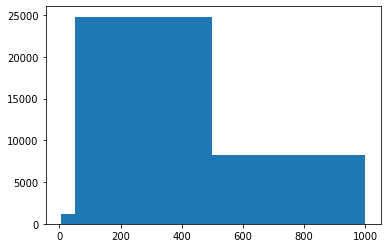

In [66]:
print("maximum length:", max_length(X_train.clean_text.tolist()))
plt.hist([len(s.split()) for s in X_train.clean_text.tolist()],bins=[5, 50, 500, 1000])

In [67]:
train_df['target'].dtype

dtype('int64')

In [68]:
'''
args = {
   'output_dir': 'outputs/',
   'cache_dir': 'cache/',
   'fp16': True,
   'fp16_opt_level': 'O1',
   'max_seq_length': 256,
   'train_batch_size': 8,
   'eval_batch_size': 8,
   'gradient_accumulation_steps': 1,
   'num_train_epochs': 3,
   'weight_decay': 0,
   'learning_rate': 4e-5,
   'adam_epsilon': 1e-8,
   'warmup_ratio': 0.06,
   'warmup_steps': 0,
   'max_grad_norm': 1.0,
   'logging_steps': 50,
   'evaluate_during_training': False,
   'save_steps': 2000,
   'eval_all_checkpoints': True,
   'use_tensorboard': True,
   'overwrite_output_dir': True,
   'reprocess_input_data': False,
}
'''
#, 'max_seq_length':24
model = ClassificationModel('xlnet', 'xlnet-base-cased', args={'num_train_epochs':4, 'train_batch_size':8, 'max_seq_length':256, 'fp16':False})

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df, acc=sklearn.metrics.accuracy_score)

/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:249: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


/usr/local/lib/python3.6/dist-packages/transformers/modeling_xlnet.py:271: UserWarning: Mixed memory format inputs detected while calling the operator. The operator will output contiguous tensor even if some of the inputs are in channels_last format. (Triggered internally at  /pytorch/aten/src/ATen/native/TensorIterator.cpp:918.)
  attn_score = (ac + bd + ef) * self.scale


Running loss: 0.752656

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Running loss: 0.000713


Running loss: 0.695964


Running loss: 0.000329


Running loss: 0.000183



INFO:simpletransformers.classification.classification_model: Training of xlnet model complete. Saved to outputs/.
/usr/local/lib/python3.6/dist-packages/simpletransformers/classification/classification_model.py:587: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9982168059672403, 'tp': 4323, 'tn': 4649, 'fp': 1, 'fn': 7, 'acc': 0.9991091314031181, 'eval_loss': 0.007784225786313838}


In [ ]:
predictions, raw_outputs = model.predict(df_test.clean_text.tolist())

INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.
